In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from ipaddress import ip_address

def run_anomaly_detection_isoforest(df, features_to_use, out_csv):
    """
    A generic function to run the Isolation Forest anomaly detection pipeline.
    """
    df_work = df.copy()
    print(f"[*] Preprocessing {out_csv}...")

    # --- Preprocessing ---
    for col in features_to_use:
        if df_work[col].dtype == 'object':
            # Handle IP addresses by converting to integers
            if 'IP' in col or col in ['Source', 'Destination']:
                # This function will handle IPv4 and ignore non-IP strings
                def ip_to_int(ip_str):
                    try:
                        return int(ip_address(ip_str))
                    except ValueError:
                        return np.nan
                df_work[col] = df_work[col].apply(ip_to_int)
            else: # Handle other categorical strings like 'Protocol'
                le = LabelEncoder()
                df_work[col] = le.fit_transform(df_work[col].astype(str))

    df_work.dropna(subset=features_to_use, inplace=True)
    if df_work.empty:
        print(f"    [!] No data left for {out_csv} after preprocessing. Skipping.")
        return

    # --- Feature Scaling ---
    X = df_work[features_to_use].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- Isolation Forest Model ---
    print(f"[*] Training Isolation Forest model for {out_csv}...")
    model = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)
    model.fit(X_scaled)

    # --- Anomaly Scoring ---
    # The decision_function returns the anomaly score. Lower is more anomalous.
    scores = model.decision_function(X_scaled)
    df_work['anomaly_score'] = scores

    # Sort by score (ascending, since lower is more anomalous)
    results = df_work.sort_values(by='anomaly_score', ascending=True)

    # Save the results
    results.to_csv(out_csv, index=False)
    print(f"    [+] Results saved to {out_csv}")

    # --- Display Top Anomalies ---
    print(f"\n--- Top 5 Anomalies for {out_csv} ---")
    # Get original data rows corresponding to top anomalies for context
    top_anomalies_context = df.loc[results.head().index]
    top_anomalies_scores = results['anomaly_score'].head().values

    # Combine context and scores for display
    display_df = top_anomalies_context.copy()
    display_df['anomaly_score'] = top_anomalies_scores
    print(display_df)
    print("-" * 50)


# --- Main Execution ---
if __name__ == "__main__":

    try:
        print("\n" + "="*20)
        print("Processing Midterm_53_group.csv")
        print("="*20)
        df_midterm = pd.read_csv('../datasets/Midterm_53_group.csv')
        features_midterm = ['Time', 'Source', 'Destination', 'Protocol', 'Length']
        run_anomaly_detection_isoforest(df_midterm, features_midterm, 'anomalies_midterm.csv')
    except FileNotFoundError:
        print("[!] Could not find Midterm_53_group.csv. Please make sure it's in the same directory.")
    except Exception as e:
        print(f"[!] An error occurred while processing Midterm_53_group.csv: {e}")


Processing Midterm_53_group.csv
[*] Preprocessing anomalies_midterm.csv...
[*] Training Isolation Forest model for anomalies_midterm.csv...
    [+] Results saved to anomalies_midterm.csv

--- Top 5 Anomalies for anomalies_midterm.csv ---
            Time         Source   No.      Destination Protocol  Length  \
45     38.899245        0.0.0.0    46  255.255.255.255     DHCP     364   
398    47.406556        0.0.0.0   399  255.255.255.255     DHCP     339   
25     30.033472  192.167.6.248    26  192.167.255.255  BROWSER     243   
606   142.013711  192.167.8.160   607  192.167.255.255  BROWSER     243   
1156  235.155596      10.27.3.2  1157    192.167.7.162      DNS     124   

                                                   Info  anomaly_score  
45            DHCP Request  - Transaction ID 0x10174903      -0.264068  
398           DHCP Request  - Transaction ID 0xccb38338      -0.263034  
25    Host Announcement DESKTOP-099UQRG, Workstation...      -0.262003  
606   Host Announc

/tmp/ipykernel_267240/2465752804.py:5: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  results_df = pd.read_csv('anomalies_midterm.csv')


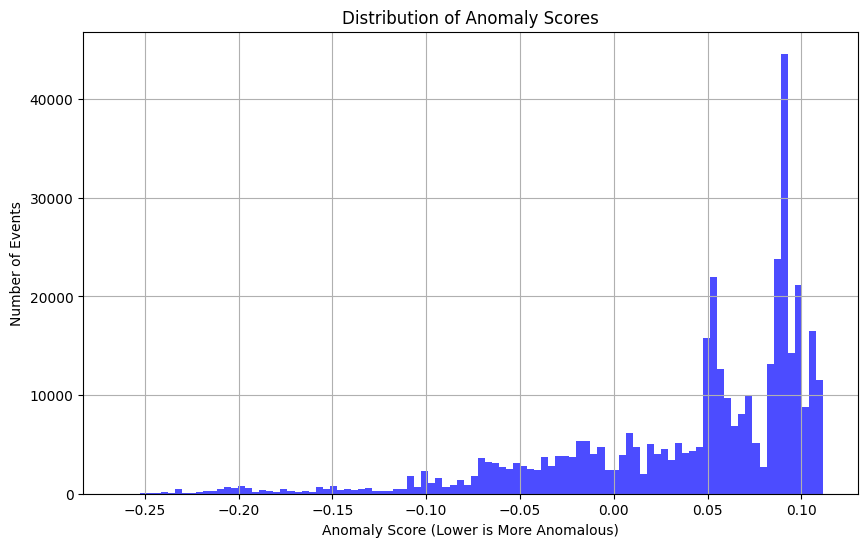

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results from one of your files
results_df = pd.read_csv('anomalies_midterm.csv')

# Plot a histogram of the anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(results_df['anomaly_score'], bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score (Lower is More Anomalous)')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()

In [9]:
import pandas as pd

def classify_threats(results_csv_path, output_csv_path):
    """
    Loads a CSV with anomaly scores and classifies each event into threat levels
    based on score quantiles.
    """
    try:
        # Load the dataframe with anomaly scores
        df = pd.read_csv(results_csv_path)
    except FileNotFoundError:
        print(f"[!] ERROR: The file '{results_csv_path}' was not found.")
        print("Please run the previous anomaly detection script first to generate this file.")
        return

    # --- 1. Define Thresholds using Quantiles ---
    # Since lower scores are more anomalous, we use lower quantiles
    crit_threshold = df['anomaly_score'].quantile(0.001) # Top 0.1%
    high_threshold = df['anomaly_score'].quantile(0.01)  # Top 1%
    elev_threshold = df['anomaly_score'].quantile(0.05)  # Top 5%

    print("--- Calculated Anomaly Score Thresholds ---")
    print(f"Level 1 (Elevated) Threshold: < {elev_threshold:.4f}")
    print(f"Level 2 (High)     Threshold: < {high_threshold:.4f}")
    print(f"Level 3 (Critical) Threshold: < {crit_threshold:.4f}")


    # --- 2. Define a function to apply the labels ---
    def assign_threat_level(score):
        if score < crit_threshold:
            return 'Level 3 (Critical)'
        elif score < high_threshold:
            return 'Level 2 (High)'
        elif score < elev_threshold:
            return 'Level 1 (Elevated)'
        else:
            return 'Normal'

    # --- 3. Create the new 'Threat_Level' column ---
    df['Threat_Level'] = df['anomaly_score'].apply(assign_threat_level)


    # --- 4. Display the results ---
    print("\n--- Distribution of Threat Levels ---")
    print(df['Threat_Level'].value_counts())

    # --- 5. Save the new dataframe ---
    df.to_csv(output_csv_path, index=False)
    print(f"\n[+] Results with threat levels saved to '{output_csv_path}'")

    # Show the top anomalies with their new labels
    print("\n--- Top Anomalies with new Threat Levels ---")
    print(df.sort_values(by='anomaly_score').head(10))


# --- Main Execution ---
if __name__ == "__main__":
    # Use the output from our previous analysis as the input here
    results_file = 'anomalies_midterm.csv'
    classified_output_file = 'threat_levels_midterm.csv'
    classify_threats(results_file, classified_output_file)


/tmp/ipykernel_267240/3811295277.py:10: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(results_csv_path)


--- Calculated Anomaly Score Thresholds ---
Level 1 (Elevated) Threshold: < -0.0932
Level 2 (High)     Threshold: < -0.1978
Level 3 (Critical) Threshold: < -0.2338

--- Distribution of Threat Levels ---
Threat_Level
Normal                373835
Level 1 (Elevated)     15740
Level 2 (High)          3542
Level 3 (Critical)       394
Name: count, dtype: int64

[+] Results with threat levels saved to 'threat_levels_midterm.csv'

--- Top Anomalies with new Threat Levels ---
         Time      Source   No. Destination  Protocol  Length  \
0   38.899245           0    46  4294967295         2     364   
1   47.406556           0   399  4294967295         2     339   
2   30.033472  3232171768    26  3232235519         1     243   
3  142.013711  3232172192   607  3232235519         1     243   
4  235.155596   169542402  1157  3232171938         3     124   
5  171.706437           0   691  4294967295         2     364   
6  169.315151           0   680  4294967295         2     364   
7  147.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from ipaddress import ip_address
import shap
import os
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')


def ip_to_int(ip_str):
    """Convert IP address to integer, handle non-IP strings."""
    try:
        return int(ip_address(ip_str))
    except ValueError:
        return np.nan


def train_random_forest_and_shap(X_scaled, anomaly_scores, feature_names):
    """Train RandomForest and create SHAP explainer for anomaly score explanation."""
    print("  🌲 Training Random Forest for SHAP explanations...")
    
    # Train Random Forest on anomaly scores
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_scaled, anomaly_scores)
    
    # Create SHAP explainer
    print("  🔍 Creating SHAP explainer...")
    # Use a sample of data for faster explainer creation
    sample_size = min(200, len(X_scaled))
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    sample_data = X_scaled[sample_indices]
    
    explainer = shap.TreeExplainer(rf_model, data=sample_data, feature_perturbation="interventional")
    
    print("  ✅ RandomForest and SHAP explainer ready.")
    return rf_model, explainer


def save_models(dataset_name, isolation_forest, scaler, rf_model, shap_explainer, feature_names, label_encoders=None):
    """Save all models for a specific dataset"""
    model_dir = f"saved_models/{dataset_name}"
    os.makedirs(model_dir, exist_ok=True)
    
    # Save Isolation Forest model
    joblib.dump(isolation_forest, f"{model_dir}/isolation_forest.pkl")
    print(f"    ✅ Isolation Forest saved")
    
    # Save scaler
    joblib.dump(scaler, f"{model_dir}/scaler.pkl")
    print(f"    ✅ Scaler saved")
    
    # Save Random Forest model
    joblib.dump(rf_model, f"{model_dir}/random_forest.pkl")
    print(f"    ✅ RandomForest saved")
    
    # Save SHAP explainer
    with open(f"{model_dir}/shap_explainer.pkl", 'wb') as f:
        pickle.dump(shap_explainer, f)
    print(f"    ✅ SHAP explainer saved")
    
    # Save feature names
    with open(f"{model_dir}/feature_names.pkl", 'wb') as f:
        pickle.dump(feature_names, f)
    print(f"    ✅ Feature names saved")
    
    # Save label encoders if they exist
    if label_encoders:
        with open(f"{model_dir}/label_encoders.pkl", 'wb') as f:
            pickle.dump(label_encoders, f)
        print(f"    ✅ Label encoders saved")
    
    print(f"  💾 All models saved to {model_dir}")


def compute_shap_analysis(shap_explainer, X_scaled, feature_names, top_n=5):
    """Compute and display SHAP analysis for top anomalies."""
    print("  📊 Computing SHAP values for anomaly explanation...")
    
    # Get SHAP values for a sample of data
    sample_size = min(100, len(X_scaled))
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    sample_data = X_scaled[sample_indices]
    
    shap_values = shap_explainer.shap_values(sample_data)
    
    # Get feature importance
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\n  --- Top Feature Importances for Anomaly Detection ---")
    print(importance_df.head(top_n))
    
    return shap_values, importance_df


def run_anomaly_detection_isoforest(df, features_to_use, out_csv, model_name):
    """
    Enhanced Isolation Forest anomaly detection pipeline with model saving and SHAP analysis.
    """
    df_work = df.copy()
    print(f"[*] Preprocessing {out_csv}...")
    
    # Store label encoders for saving
    label_encoders = {}
    
    # --- Preprocessing ---
    for col in features_to_use:
        if df_work[col].dtype == 'object':
            # Handle IP addresses by converting to integers
            if 'IP' in col or col in ['Source', 'Destination']:
                df_work[col] = df_work[col].apply(ip_to_int)
            else: # Handle other categorical strings like 'Protocol'
                le = LabelEncoder()
                df_work[col] = le.fit_transform(df_work[col].astype(str))
                label_encoders[col] = le

    df_work.dropna(subset=features_to_use, inplace=True)
    if df_work.empty:
        print(f"    [!] No data left for {out_csv} after preprocessing. Skipping.")
        return

    # --- Feature Scaling ---
    print(f"[*] Scaling features for {out_csv}...")
    X = df_work[features_to_use].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # --- Isolation Forest Model ---
    print(f"[*] Training Isolation Forest model for {out_csv}...")
    isolation_forest = IsolationForest(contamination='auto', random_state=42, n_jobs=-1)
    isolation_forest.fit(X_scaled)

    # --- Anomaly Scoring ---
    print(f"[*] Computing anomaly scores for {out_csv}...")
    # The decision_function returns the anomaly score. Lower is more anomalous.
    scores = isolation_forest.decision_function(X_scaled)
    df_work['anomaly_score'] = scores

    # Convert scores to positive values (higher = more anomalous) for better interpretation
    anomaly_scores_positive = -scores  # Invert so higher values mean more anomalous
    df_work['anomaly_score_positive'] = anomaly_scores_positive

    # --- Train Random Forest and SHAP for Explainability ---
    rf_model, shap_explainer = train_random_forest_and_shap(X_scaled, anomaly_scores_positive, features_to_use)

    # --- SHAP Analysis ---
    shap_values, importance_df = compute_shap_analysis(shap_explainer, X_scaled, features_to_use)

    # --- Classify into threat levels based on anomaly scores ---
    print(f"[*] Classifying threats into levels for {out_csv}...")
    level_3_threshold = np.percentile(anomaly_scores_positive, 99)
    level_2_threshold = np.percentile(anomaly_scores_positive, 95)
    level_1_threshold = np.percentile(anomaly_scores_positive, 90)

    conditions = [
        anomaly_scores_positive > level_3_threshold,
        anomaly_scores_positive > level_2_threshold,
        anomaly_scores_positive > level_1_threshold
    ]
    levels = ['Level 3 Threat (Critical)', 'Level 2 Threat (High)', 'Level 1 Threat (Medium)']
    df_work['Threat_Level'] = np.select(conditions, levels, default='Not a Threat')

    # Sort by positive anomaly score (descending, since higher is more anomalous)
    results = df_work.sort_values(by='anomaly_score_positive', ascending=False)

    # Save the results
    results.to_csv(out_csv, index=False)
    print(f"    [+] Results saved to {out_csv}")

    # --- Display Results ---
    print(f"\n--- Threat Level Distribution for {out_csv} ---")
    print(results['Threat_Level'].value_counts())

    print(f"\n--- Top 5 Anomalies for {out_csv} ---")
    # Get original data rows corresponding to top anomalies for context
    top_anomalies_context = df.loc[results.head().index]
    top_anomalies_scores = results['anomaly_score_positive'].head().values
    top_anomalies_levels = results['Threat_Level'].head().values

    # Combine context and scores for display
    display_df = top_anomalies_context.copy()
    display_df['anomaly_score_positive'] = top_anomalies_scores
    display_df['Threat_Level'] = top_anomalies_levels
    print(display_df)
    
    print("\n--- Feature Importance Analysis ---")
    print(importance_df)
    print("-" * 50)

    # --- Save Models ---
    print(f"[*] Saving models for {model_name}...")
    save_models(
        model_name, 
        isolation_forest, 
        scaler, 
        rf_model, 
        shap_explainer, 
        features_to_use,
        label_encoders if label_encoders else None
    )


# --- Main Execution ---
if __name__ == "__main__":
    
    # Create main models directory
    os.makedirs("saved_models", exist_ok=True)
    
    print("🚀 Starting Enhanced Isolation Forest Anomaly Detection Pipeline with Model Saving\n")

    try:
        print("\n" + "="*20)
        print("Processing Midterm_53_group.csv")
        print("="*20)
        df_midterm = pd.read_csv('../datasets/Midterm_53_group.csv')
        features_midterm = ['Time', 'Source', 'Destination', 'Protocol', 'Length']
        run_anomaly_detection_isoforest(
            df_midterm, 
            features_midterm, 
            'anomalies_midterm.csv',
            'midterm_network_analysis'
        )
    except FileNotFoundError:
        print("[!] Could not find Midterm_53_group.csv. Please make sure it's in the datasets directory.")
    except Exception as e:
        print(f"[!] An error occurred while processing Midterm_53_group.csv: {e}")

    print("\n🎉🎉 Pipeline finished successfully! 🎉🎉")
    print("📁 All models saved in 'saved_models' directory")
    
    # Print final directory structure
    print("\n📂 Final saved_models directory structure:")
    for root, dirs, files in os.walk("saved_models"):
        level = root.replace("saved_models", "").count(os.sep)
        indent = " " * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = " " * 2 * (level + 1)
        for file in files:
            print(f"{subindent}{file}")


🚀 Starting Enhanced Isolation Forest Anomaly Detection Pipeline with Model Saving


Processing Midterm_53_group.csv
[*] Preprocessing anomalies_midterm.csv...
[*] Scaling features for anomalies_midterm.csv...
[*] Training Isolation Forest model for anomalies_midterm.csv...
[*] Computing anomaly scores for anomalies_midterm.csv...
  🌲 Training Random Forest for SHAP explanations...
  🔍 Creating SHAP explainer...
  ✅ RandomForest and SHAP explainer ready.
  📊 Computing SHAP values for anomaly explanation...

  --- Top Feature Importances for Anomaly Detection ---
       feature  importance
0         Time    0.023023
3     Protocol    0.019821
4       Length    0.018177
2  Destination    0.000000
1       Source    0.000000
[*] Classifying threats into levels for anomalies_midterm.csv...
    [+] Results saved to anomalies_midterm.csv

--- Threat Level Distribution for anomalies_midterm.csv ---
Threat_Level
Not a Threat                 354161
Level 1 Threat (Medium)       19674
Level 2 Thre

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from ipaddress import ip_address
import shap
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')


def ip_to_int(ip_str):
    """Convert IP address to integer, handle non-IP strings."""
    try:
        return int(ip_address(ip_str))
    except ValueError:
        return np.nan


def load_saved_models(model_path):
    """Load all pre-saved models and components."""
    print(f"[*] Loading saved models from {model_path}...")
    
    # Load Isolation Forest model
    isolation_forest = joblib.load(f"{model_path}/isolation_forest.pkl")
    print("    ✅ Isolation Forest model loaded")
    
    # Load scaler
    scaler = joblib.load(f"{model_path}/scaler.pkl")
    print("    ✅ Scaler loaded")
    
    # Load Random Forest model
    rf_model = joblib.load(f"{model_path}/random_forest.pkl")
    print("    ✅ Random Forest model loaded")
    
    # Load SHAP explainer
    with open(f"{model_path}/shap_explainer.pkl", 'rb') as f:
        shap_explainer = pickle.load(f)
    print("    ✅ SHAP explainer loaded")
    
    # Load feature names
    with open(f"{model_path}/feature_names.pkl", 'rb') as f:
        feature_names = pickle.load(f)
    print("    ✅ Feature names loaded")
    
    # Load label encoders
    label_encoders = None
    try:
        with open(f"{model_path}/label_encoders.pkl", 'rb') as f:
            label_encoders = pickle.load(f)
        print("    ✅ Label encoders loaded")
    except FileNotFoundError:
        print("    ⚠️  No label encoders found")
    
    print(f"    🎯 All models successfully loaded!")
    return isolation_forest, scaler, rf_model, shap_explainer, feature_names, label_encoders


def compute_shap_analysis(shap_explainer, rf_model, X_scaled, feature_names, top_n=5):
    """Compute and display SHAP analysis for anomaly explanation."""
    print("  📊 Computing SHAP values for anomaly explanation...")
    
    # Get anomaly scores from RF model
    anomaly_scores = rf_model.predict(X_scaled)
    
    # Get SHAP values for a sample of data
    sample_size = min(100, len(X_scaled))
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    sample_data = X_scaled[sample_indices]
    
    shap_values = shap_explainer.shap_values(sample_data)
    
    # Get feature importance
    feature_importance = np.abs(shap_values).mean(0)
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\n  --- Top Feature Importances for Anomaly Detection ---")
    print(importance_df.head(top_n))
    
    return importance_df


def run_anomaly_detection_with_saved_models(df, model_path, out_csv):
    """
    Run anomaly detection using pre-saved models.
    """
    # Load all saved models
    isolation_forest, scaler, rf_model, shap_explainer, feature_names, label_encoders = load_saved_models(model_path)
    
    df_work = df.copy()
    print(f"\n[*] Preprocessing data using saved models for {out_csv}...")
    
    # --- Preprocessing using saved label encoders ---
    for col in feature_names:
        if df_work[col].dtype == 'object':
            # Handle IP addresses by converting to integers
            if 'IP' in col or col in ['Source', 'Destination']:
                df_work[col] = df_work[col].apply(ip_to_int)
            else: # Handle other categorical strings like 'Protocol'
                if label_encoders and col in label_encoders:
                    le = label_encoders[col]
                    # Transform using saved encoder, handle unknown labels
                    try:
                        df_work[col] = le.transform(df_work[col].astype(str))
                    except ValueError as e:
                        print(f"    ⚠️  Unknown labels found in {col}, using fallback encoding")
                        # Handle unknown labels by assigning them to a default value
                        unique_values = df_work[col].astype(str).unique()
                        known_values = set(le.classes_)
                        unknown_mask = ~df_work[col].astype(str).isin(known_values)
                        df_work.loc[unknown_mask, col] = le.classes_[0]  # Assign to first known class
                        df_work[col] = le.transform(df_work[col].astype(str))
                else:
                    # Fallback: create new encoder if not saved
                    le = LabelEncoder()
                    df_work[col] = le.fit_transform(df_work[col].astype(str))

    df_work.dropna(subset=feature_names, inplace=True)
    if df_work.empty:
        print(f"    [!] No data left for {out_csv} after preprocessing. Skipping.")
        return

    # --- Feature Scaling using saved scaler ---
    print(f"[*] Scaling features using saved scaler for {out_csv}...")
    X = df_work[feature_names].values
    X_scaled = scaler.transform(X)  # Use transform, not fit_transform

    # --- Anomaly Scoring using saved Isolation Forest ---
    print(f"[*] Computing anomaly scores using saved Isolation Forest for {out_csv}...")
    scores = isolation_forest.decision_function(X_scaled)
    df_work['anomaly_score'] = scores

    # Convert scores to positive values (higher = more anomalous) for better interpretation
    anomaly_scores_positive = -scores  # Invert so higher values mean more anomalous
    df_work['anomaly_score_positive'] = anomaly_scores_positive

    # --- SHAP Analysis using saved models ---
    importance_df = compute_shap_analysis(shap_explainer, rf_model, X_scaled, feature_names)

    # --- Classify into threat levels based on anomaly scores ---
    print(f"[*] Classifying threats into levels for {out_csv}...")
    level_3_threshold = np.percentile(anomaly_scores_positive, 99)
    level_2_threshold = np.percentile(anomaly_scores_positive, 95)
    level_1_threshold = np.percentile(anomaly_scores_positive, 90)

    conditions = [
        anomaly_scores_positive > level_3_threshold,
        anomaly_scores_positive > level_2_threshold,
        anomaly_scores_positive > level_1_threshold
    ]
    levels = ['Level 3 Threat (Critical)', 'Level 2 Threat (High)', 'Level 1 Threat (Medium)']
    df_work['Threat_Level'] = np.select(conditions, levels, default='Not a Threat')

    # Sort by positive anomaly score (descending, since higher is more anomalous)
    results = df_work.sort_values(by='anomaly_score_positive', ascending=False)

    # Save the results
    results.to_csv(out_csv, index=False)
    print(f"    [+] Results saved to {out_csv}")

    # --- Display Results ---
    print(f"\n--- Threat Level Distribution for {out_csv} ---")
    print(results['Threat_Level'].value_counts())

    print(f"\n--- Top 5 Anomalies for {out_csv} ---")
    # Get original data rows corresponding to top anomalies for context
    top_anomalies_context = df.loc[results.head().index]
    top_anomalies_scores = results['anomaly_score_positive'].head().values
    top_anomalies_levels = results['Threat_Level'].head().values

    # Combine context and scores for display
    display_df = top_anomalies_context.copy()
    display_df['anomaly_score_positive'] = top_anomalies_scores
    display_df['Threat_Level'] = top_anomalies_levels
    print(display_df)
    
    print("\n--- Feature Importance Analysis (from SHAP) ---")
    print(importance_df)
    print("-" * 50)


# --- Main Execution ---
if __name__ == "__main__":
    
    print("🚀 Starting Anomaly Detection using Pre-Saved Models\n")

    try:
        print("\n" + "="*20)
        print("Processing Midterm_53_group.csv with Saved Models")
        print("="*20)
        
        df_midterm = pd.read_csv('../datasets/Midterm_53_group.csv')
        model_path = 'saved_models/midterm_network_analysis'
        
        run_anomaly_detection_with_saved_models(
            df_midterm, 
            model_path, 
            'anomalies_midterm_from_saved_models.csv'
        )
        
    except FileNotFoundError as e:
        print(f"[!] File not found: {e}")
        print("    Please make sure:")
        print("    - Midterm_53_group.csv is in the ../datasets/ directory")
        print("    - All model files are in saved_models/midterm_network_analysis/ directory")
    except Exception as e:
        print(f"[!] An error occurred: {e}")

    print("\n🎉🎉 Analysis completed using saved models! 🎉🎉")


🚀 Starting Anomaly Detection using Pre-Saved Models


Processing Midterm_53_group.csv with Saved Models
[*] Loading saved models from saved_models/midterm_network_analysis...
    ✅ Isolation Forest model loaded
    ✅ Scaler loaded
    ✅ Random Forest model loaded
    ✅ SHAP explainer loaded
    ✅ Feature names loaded
    ✅ Label encoders loaded
    🎯 All models successfully loaded!

[*] Preprocessing data using saved models for anomalies_midterm_from_saved_models.csv...
[*] Scaling features using saved scaler for anomalies_midterm_from_saved_models.csv...
[*] Computing anomaly scores using saved Isolation Forest for anomalies_midterm_from_saved_models.csv...
  📊 Computing SHAP values for anomaly explanation...

  --- Top Feature Importances for Anomaly Detection ---
       feature  importance
3     Protocol    0.024631
0         Time    0.021687
4       Length    0.020281
2  Destination    0.000000
1       Source    0.000000
[*] Classifying threats into levels for anomalies_midterm_fro

In [16]:
import pandas as pd
import numpy as np
import joblib
import pickle
from ipaddress import ip_address
import warnings
warnings.filterwarnings('ignore')


def ip_to_int(ip_str):
    """Convert IP address to integer, handle non-IP strings."""
    try:
        return int(ip_address(ip_str))
    except ValueError:
        return np.nan


def load_saved_models(model_path):
    """Load all pre-saved models and components."""
    print(f"[*] Loading saved models from {model_path}...")
    
    isolation_forest = joblib.load(f"{model_path}/isolation_forest.pkl")
    scaler = joblib.load(f"{model_path}/scaler.pkl")
    rf_model = joblib.load(f"{model_path}/random_forest.pkl")
    
    with open(f"{model_path}/shap_explainer.pkl", 'rb') as f:
        shap_explainer = pickle.load(f)
    
    with open(f"{model_path}/feature_names.pkl", 'rb') as f:
        feature_names = pickle.load(f)
    
    try:
        with open(f"{model_path}/label_encoders.pkl", 'rb') as f:
            label_encoders = pickle.load(f)
    except FileNotFoundError:
        label_encoders = {}
    
    print("    ✅ All models loaded successfully!")
    return isolation_forest, scaler, rf_model, shap_explainer, feature_names, label_encoders


def preprocess_examples(df_examples, feature_names, label_encoders, scaler):
    """Preprocess examples using saved components."""
    df_work = df_examples.copy()
    
    for col in feature_names:
        if df_work[col].dtype == 'object':
            if 'IP' in col or col in ['Source', 'Destination']:
                df_work[col] = df_work[col].apply(ip_to_int)
            else:
                if col in label_encoders:
                    le = label_encoders[col]
                    unknown_mask = ~df_work[col].astype(str).isin(le.classes_)
                    if unknown_mask.any():
                        df_work.loc[unknown_mask, col] = le.classes_[0]
                    df_work[col] = le.transform(df_work[col].astype(str))
    
    X = df_work[feature_names].values
    X_scaled = scaler.transform(X)
    
    return X_scaled, df_work


def generate_explanation(shap_values, features, threshold=0.01):
    """Generate human-readable explanation from SHAP values (similar to the provided method)."""
    try:
        # Get indices of features sorted by absolute SHAP value impact
        sorted_indices = np.argsort(np.abs(shap_values))[::-1]
        
        # Take top 2-3 most important features
        top_indices = sorted_indices[:3]
        explanations = []
        
        for idx in top_indices:
            feature_name = features[idx]
            shap_val = shap_values[idx]
            
            if abs(shap_val) > threshold:  # Only include significant contributions
                direction = "increases" if shap_val > 0 else "decreases"
                explanations.append(f"{feature_name} {direction} anomaly likelihood")
        
        if explanations:
            return f"{', '.join(explanations[:2])}"
        else:
            return "No significant feature contributions detected"
            
    except Exception as e:
        return f"Explanation generation failed: {str(e)}"


def generate_explanations_for_examples(df, model_path, num_examples=12):
    """Generate explanations for multiple examples and return as DataFrame."""
    
    # Load models
    isolation_forest, scaler, rf_model, shap_explainer, feature_names, label_encoders = load_saved_models(model_path)
    
    # Select examples
    if len(df) > num_examples:
        selected_examples = df.sample(n=num_examples, random_state=42)
    else:
        selected_examples = df.copy()
    
    print(f"\n[*] Generating explanations for {len(selected_examples)} examples...")
    
    # Preprocess examples
    X_scaled, processed_df = preprocess_examples(selected_examples, feature_names, label_encoders, scaler)
    
    # Get anomaly scores
    isolation_scores = isolation_forest.decision_function(X_scaled)
    anomaly_scores_positive = -isolation_scores
    
    # Get SHAP values
    shap_values = shap_explainer.shap_values(X_scaled)
    
    # Create results DataFrame
    results = []
    
    for i, (idx, row) in enumerate(selected_examples.iterrows()):
        # Generate explanation using the similar method
        explanation = generate_explanation(shap_values[i], feature_names)
        
        # Determine threat level
        if anomaly_scores_positive[i] > np.percentile(anomaly_scores_positive, 99):
            threat_level = "Level 3 Threat (Critical)"
        elif anomaly_scores_positive[i] > np.percentile(anomaly_scores_positive, 95):
            threat_level = "Level 2 Threat (High)"
        elif anomaly_scores_positive[i] > np.percentile(anomaly_scores_positive, 90):
            threat_level = "Level 1 Threat (Medium)"
        else:
            threat_level = "Not a Threat"
        
        # Create result record
        result = {
            'Row_Index': idx,
            'Anomaly_Score': round(anomaly_scores_positive[i], 4),
            'Threat_Level': threat_level,
            'Explanation': explanation
        }
        
        # Add original feature values
        for feature in feature_names:
            result[f'Original_{feature}'] = row[feature]
        
        results.append(result)
    
    results_df = pd.DataFrame(results)
    return results_df


def main():
    """Main execution function."""
    print("🚀 Starting SHAP Explanation Generation for Dataset Examples\n")
    
    try:
        # Load dataset
        df = pd.read_csv('../datasets/Midterm_53_group.csv')
        print(f"📄 Loaded dataset with {len(df)} records")
        
        # Generate explanations
        model_path = 'saved_models/midterm_network_analysis'
        results_df = generate_explanations_for_examples(df, model_path, num_examples=12)
        
        # Display results
        print("\n" + "="*100)
        print("📊 ANOMALY EXPLANATIONS FOR SELECTED EXAMPLES")
        print("="*100)
        
        # Display in a clean format
        for i, row in results_df.iterrows():
            print(f"\n🔍 **Example {i+1} (Row {row['Row_Index']})**")
            print(f"   📈 Anomaly Score: {row['Anomaly_Score']}")
            print(f"   🚨 Threat Level: {row['Threat_Level']}")
            print(f"   💭 Explanation: {row['Explanation']}")
            
            # Show original data
            original_data = []
            for col in results_df.columns:
                if col.startswith('Original_'):
                    feature_name = col.replace('Original_', '')
                    original_data.append(f"{feature_name}={row[col]}")
            print(f"   📋 Data: {', '.join(original_data)}")
            print("-" * 80)
        
        # Save to CSV
        results_df.to_csv('anomaly_explanations.csv', index=False)
        print(f"\n💾 Results saved to 'anomaly_explanations.csv'")
        
        # Create a summary table for better readability
        summary_df = results_df[['Row_Index', 'Anomaly_Score', 'Threat_Level', 'Explanation']].copy()
        
        print(f"\n📋 **SUMMARY TABLE**")
        print(summary_df.to_string(index=False, max_colwidth=50))
        
    except FileNotFoundError as e:
        print(f"❌ File not found: {e}")
    except Exception as e:
        print(f"❌ Error occurred: {e}")


# Additional function to generate explanations for specific rows
def explain_specific_rows(csv_path, model_path, row_indices):
    """Generate explanations for specific row indices."""
    
    df = pd.read_csv(csv_path)
    selected_df = df.iloc[row_indices]
    
    # Load models
    isolation_forest, scaler, rf_model, shap_explainer, feature_names, label_encoders = load_saved_models(model_path)
    
    # Preprocess
    X_scaled, processed_df = preprocess_examples(selected_df, feature_names, label_encoders, scaler)
    
    # Get scores and SHAP values
    isolation_scores = isolation_forest.decision_function(X_scaled)
    anomaly_scores_positive = -isolation_scores
    shap_values = shap_explainer.shap_values(X_scaled)
    
    # Generate explanations
    explanations = []
    for i, (idx, row) in enumerate(selected_df.iterrows()):
        explanation = generate_explanation(shap_values[i], feature_names)
        explanations.append({
            'Row_Index': idx,
            'Anomaly_Score': round(anomaly_scores_positive[i], 4),
            'Explanation': explanation,
            'Raw_Data': dict(row)
        })
    
    return explanations


if __name__ == "__main__":
    main()
    
    # Example: Explain specific rows
    print("\n" + "="*60)
    print("🎯 EXPLANATIONS FOR SPECIFIC ROWS")
    print("="*60)
    
    try:
        specific_explanations = explain_specific_rows(
            '../datasets/Midterm_53_group.csv', 
            'saved_models/midterm_network_analysis', 
            [0, 10, 20, 50, 100]  # Explain rows 0, 10, 20, 50, 100
        )
        
        for exp in specific_explanations:
            print(f"\n📍 Row {exp['Row_Index']} (Score: {exp['Anomaly_Score']})")
            print(f"   {exp['Explanation']}")
    except Exception as e:
        print(f"Could not generate specific row explanations: {e}")


🚀 Starting SHAP Explanation Generation for Dataset Examples

📄 Loaded dataset with 394136 records
[*] Loading saved models from saved_models/midterm_network_analysis...
    ✅ All models loaded successfully!

[*] Generating explanations for 12 examples...

📊 ANOMALY EXPLANATIONS FOR SELECTED EXAMPLES

🔍 **Example 1 (Row 351660)**
   📈 Anomaly Score: -0.0251
   🚨 Threat Level: Not a Threat
   💭 Explanation: Time increases anomaly likelihood, Protocol decreases anomaly likelihood
   📋 Data: Time=1159.739058, Source=192.167.7.162, Destination=74.125.9.169, Protocol=TCP, Length=54
--------------------------------------------------------------------------------

🔍 **Example 2 (Row 147074)**
   📈 Anomaly Score: 0.1159
   🚨 Threat Level: Level 3 Threat (Critical)
   💭 Explanation: Protocol increases anomaly likelihood, Length increases anomaly likelihood
   📋 Data: Time=684.013951, Source=35.244.181.201, Destination=192.167.7.162, Protocol=TLSv1.2, Length=580
----------------------------------